#Import Package

In [10]:
import pandas as pd
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing as HWSE
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import statsmodels.api as sm
import warnings

In [11]:
df =pd.read_csv("/content/drive/MyDrive/file data set project/Total User Subscribe.csv")
print(df.head())

                                     Week  Number Subscriber
0   Sep 30, 2019 to Oct 6, 2019 (Week 40)              51962
1   Oct 7, 2019 to Oct 13, 2019 (Week 41)              62433
2  Oct 14, 2019 to Oct 20, 2019 (Week 42)              61552
3  Oct 21, 2019 to Oct 27, 2019 (Week 43)              54288
4   Oct 28, 2019 to Nov 3, 2019 (Week 44)              68773


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Week               118 non-null    object
 1   Number Subscriber  118 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


#Split Data into Train Data and Test Data

In [14]:
# Split the data into train and test sets
train_data = df[:int(0.8 * len(df))]
test_data = df[int(0.8 * len(df)):]

In [15]:
import plotly.express as px
figure = px.line(train_data, x="Week",y="Number Subscriber", title="Number of Subscriber")
figure.show()

<Figure size 640x480 with 0 Axes>

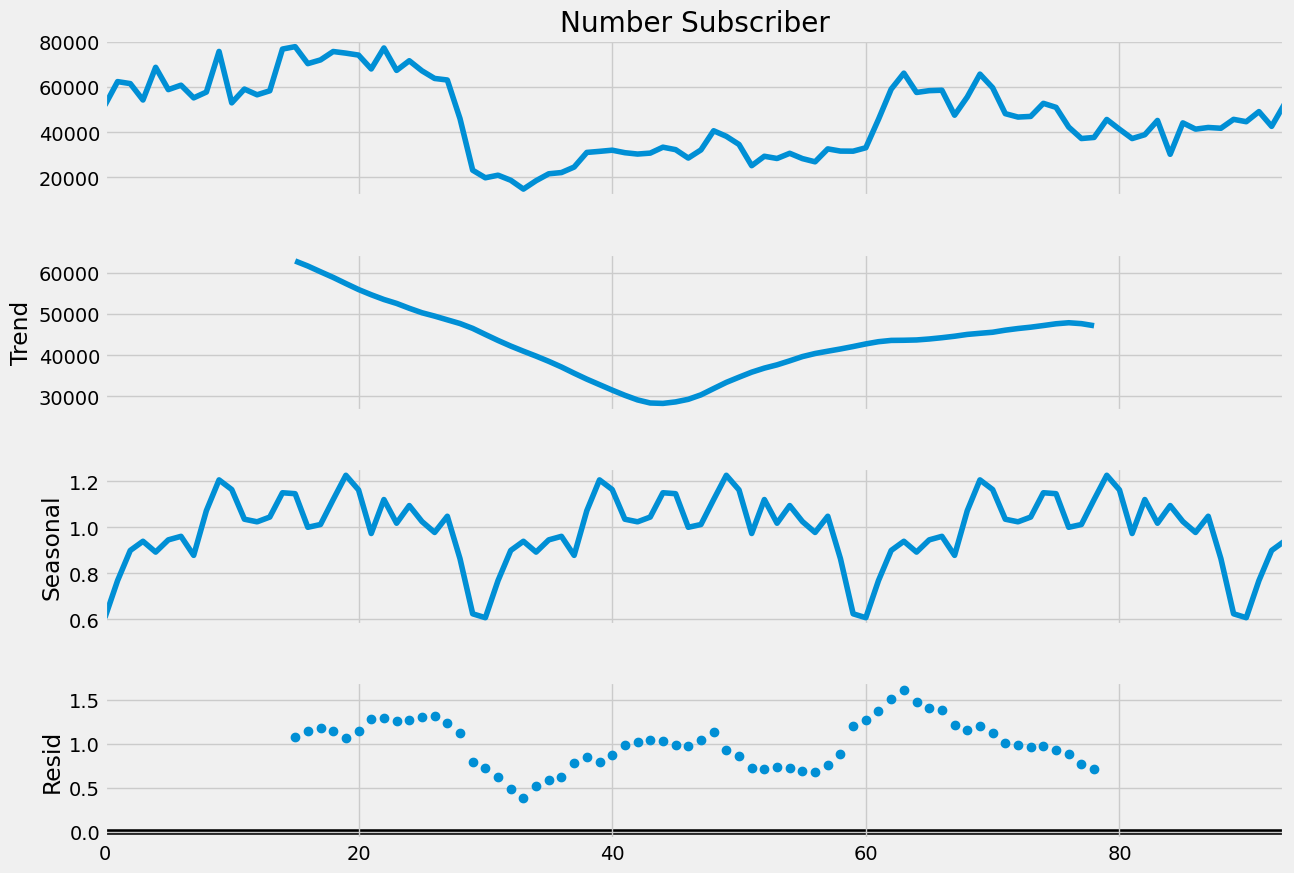

In [16]:
#checking data seasonal
result = seasonal_decompose(train_data['Number Subscriber'], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

* Seasonal: The data clearly exhibits a seasonal pattern, as seen from the seasonal component. This pattern is important to consider in forecasting models.
* Trend: There are significant long-term changes in the data. Understanding these changes is crucial for long-term business strategies.
* Anomalies or Unexpected Changes: The residual component shows random variability likely due to external factors not accounted for in the model. This might include unexpected events like the COVID-19 pandemic or national holiday and new year's eve.

In [18]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller
df
def test_stationarity(timeseries):
    # Perform Dickey-Fuller Test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Make the data stationary
def make_stationary(timeseries):
    # Calculate the difference between consecutive values
    stationary_timeseries = timeseries.diff().dropna()
    # Check if the data is now stationary
    test_stationarity(stationary_timeseries)
    return stationary_timeseries

# Apply the make_stationary function to the data
stationary_data = make_stationary(train_data['Number Subscriber'])

Results of Dickey-Fuller Test:
Test Statistic                -1.086858e+01
p-value                        1.387088e-19
#Lags Used                     0.000000e+00
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


Based on the results of the Dickey-Fuller test provided after running the make_stationary script, we see that the data is already stationary after one differencing. The test results show a very small p-value (close to zero) and a Test Statistic much smaller (more negative) than the critical values at all significance levels.

**Conclusion:**
The value of d is 1

# Plot ACF

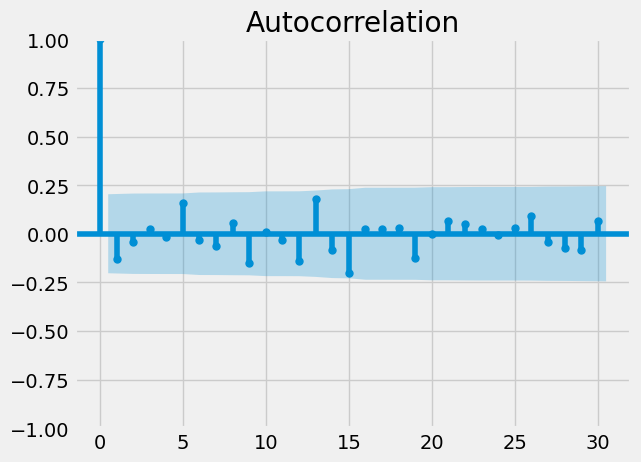

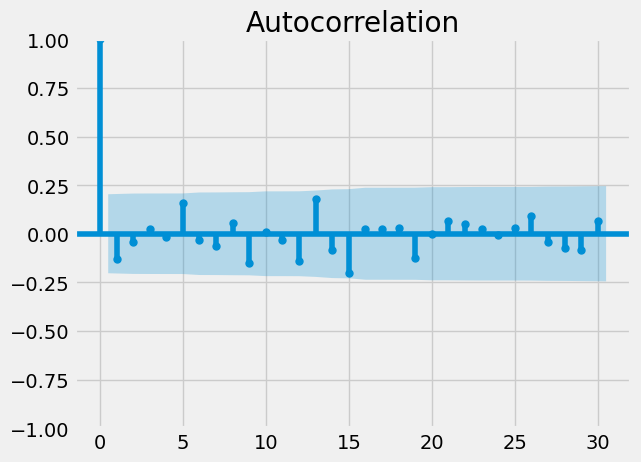

In [19]:
plot_acf(stationary_data, lags=30)

This Plot:
The significant spike at lag 0 suggests that there is a strong correlation between consecutive observations, implying the presence of an autoregressive component.
The rest of the lags show mostly non-significant autocorrelations, suggesting that there is no strong periodicity or seasonality at those lags.

**Conclusion:** The value of q is 0

# Plot PACF

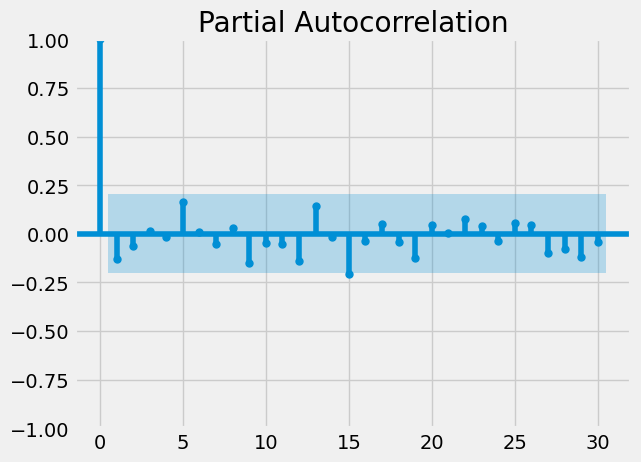

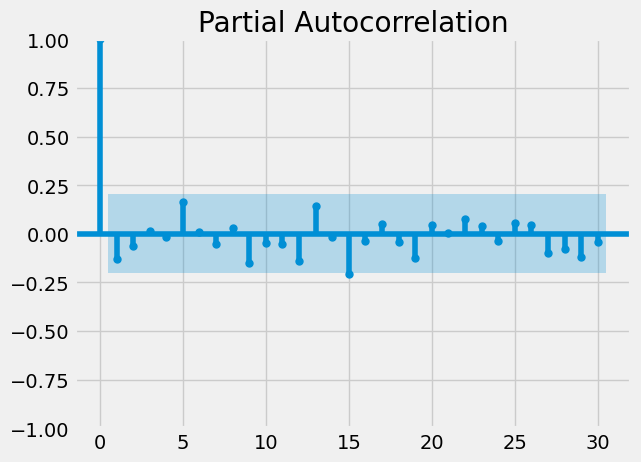

In [20]:
plot_pacf(stationary_data, lags=30)

Based on the PACF plot, it is evident that the time series has a significant partial autocorrelation at lag 0.

**Conclusion:** The value of p is 0

In [23]:
# create model sarimax

p=0
d=1
q=0

model_sarimax = sm.tsa.statespace.SARIMAX(train_data['Number Subscriber'], order=(p, d, q), seasonal_order=(p, d, q, 12))
model_sarimax = model_sarimax.fit()
print(model_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  Number Subscriber   No. Observations:                   94
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -867.820
Date:                            Mon, 17 Jun 2024   AIC                           1737.640
Time:                                    05:10:28   BIC                           1740.035
Sample:                                         0   HQIC                          1738.601
                                             - 94                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.159e+08   1.72e+07      6.759      0.000    8.23e+07     1.5e+08
Ljung-Box (L1) (Q):                

In [24]:
# Calculate the starting and ending points for prediction
start = len(train_data)
end = len(train_data) + len(test_data)-1 # end should be after start

# Predict values
prediction_test_sarimax = model_sarimax.predict(start, end)
print(prediction_test_sarimax)

94     54066.0
95     60384.0
96     45393.0
97     59311.0
98     56536.0
99     57265.0
100    56926.0
101    60863.0
102    59834.0
103    64307.0
104    57772.0
105    67519.0
106    69223.0
107    75541.0
108    60550.0
109    74468.0
110    71693.0
111    72422.0
112    72083.0
113    76020.0
114    74991.0
115    79464.0
116    72929.0
117    82676.0
Name: predicted_mean, dtype: float64


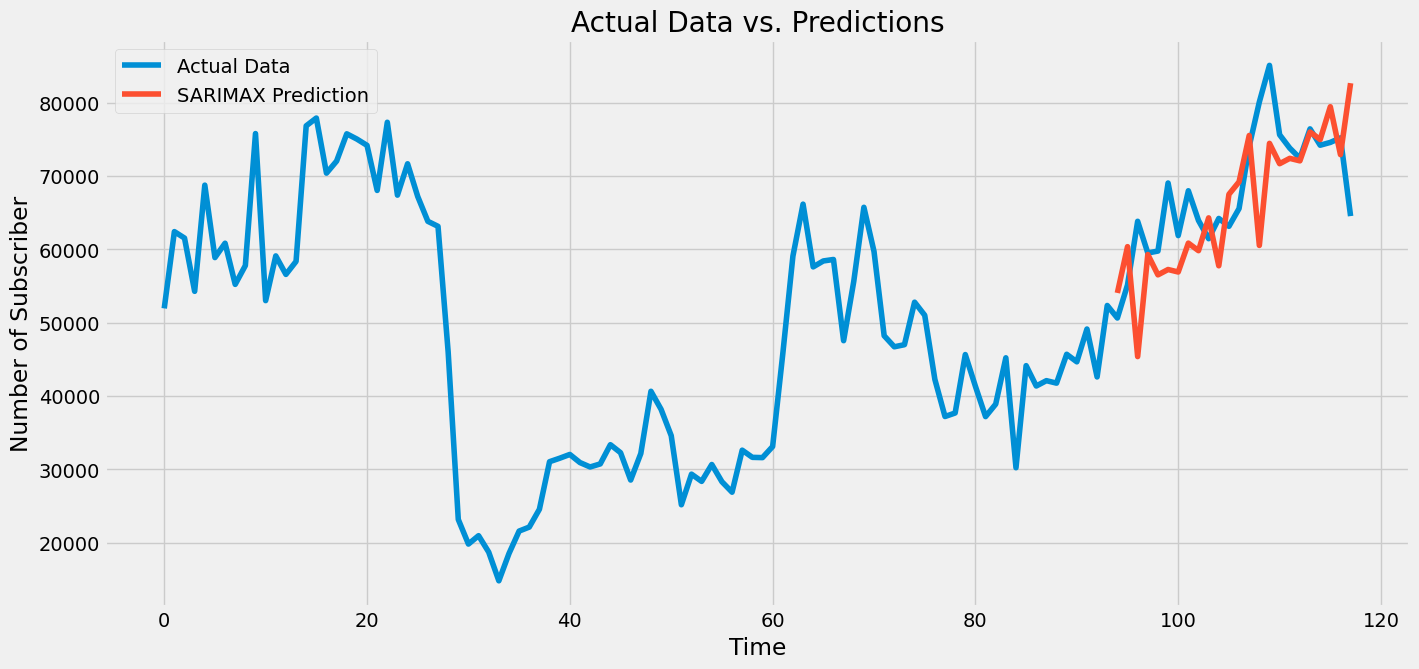

MAPE SARIMAX: 0.08576014649081691


In [27]:
from sklearn.metrics import mean_absolute_percentage_error # Import the function

# compare chat actual data vs predict SARIMAX vs HWSE and calculate MAPE

# Calculate the mean absolute percentage error (MAPE) for each model
mape_sarimax = mean_absolute_percentage_error(test_data['Number Subscriber'], prediction_test_sarimax)

# Create a line chart with actual data, SARIMAX prediction, and HWSE prediction
fig = plt.figure(figsize=(15, 7))
plt.plot(df['Number Subscriber'], label='Actual Data')
plt.plot(test_data.index, prediction_test_sarimax, label='SARIMAX Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Subscriber')
plt.title('Actual Data vs. Predictions')
plt.legend()
plt.show()
# Print the results
print("MAPE SARIMAX:", mape_sarimax)

# Predict for next 12 month

In [31]:
#predict next 12 with sarimax from dataframe

next_12_week = model_sarimax.predict(start=len(df), end=len(df)+11, dynamic=False)
print(next_12_week)

118    84380.0
119    90698.0
120    75707.0
121    89625.0
122    86850.0
123    87579.0
124    87240.0
125    91177.0
126    90148.0
127    94621.0
128    88086.0
129    97833.0
Name: predicted_mean, dtype: float64


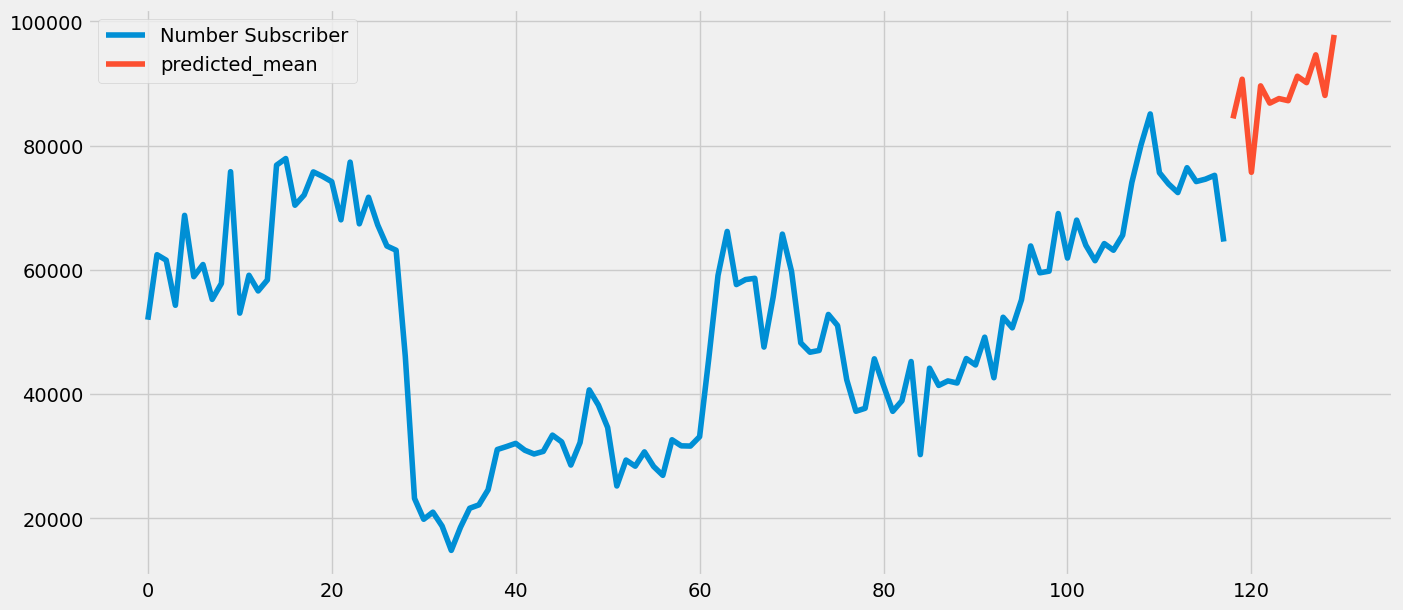

In [32]:
df['Number Subscriber'].plot(legend=True, figsize=(15, 7))
next_12_week.plot(legend=True)
plt.show()